# Library Imports

In [5]:
import sys
import os
directory_path = os.path.abspath(os.path.join('..'))
utils_path = os.path.abspath(os.path.join('../utils'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    sys.path.append(utils_path)

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from utils.Validator import *
from utils.Combinations import *
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Network Data Preparation

## Users Followers

In [3]:
df_user_followers = pd.read_csv(r"../data/interim/UserFollowers.csv",dtype=str)
df_user_followers.head()

,UserId,FollowerUserId
0,368,993
1,368,1902
2,368,1950
3,368,3258
4,368,3429


In [4]:
df_user_followers.to_csv(r"../data/processed/DiGraph_Followers.csv",index=False)

## Users Teams

In [7]:
df_team_memberships = pd.read_csv(r"../data/interim/TeamMemberships.csv",dtype=str)
df_team_memberships.head()

,TeamId,UserId
0,518,635
1,526,839
2,527,816
3,528,778
4,529,747


In [8]:
df_teams = pd.read_csv(r"../data/interim/Teams.csv",dtype=str)
df_teams= df_teams[["TeamId","CompetitionId","Medal"]]
df_teams.head()

,TeamId,CompetitionId,Medal
0,496,2435,NaN
1,497,2435,3.0
2,499,2435,NaN
3,500,2435,3.0
4,501,2435,NaN


In [9]:
df_teams.isnull().sum()

TeamId                 0
CompetitionId          0
Medal            5309895
dtype: int64

In [10]:
df_teams.fillna(0,inplace=True)
df_teams["Medal"] = df_teams["Medal"].astype(float)
df_teams.loc[df_teams.Medal == 3, 'MedalPoint'] = 1
df_teams.loc[df_teams.Medal == 1, 'MedalPoint'] = 3
df_teams.loc[df_teams.Medal == 2, 'MedalPoint'] = 2
df_teams.loc[df_teams.Medal == 0, 'MedalPoint'] = 0
df_teams = df_teams[["TeamId","CompetitionId","MedalPoint"]]
df_teams.head()

,TeamId,CompetitionId,MedalPoint
0,496,2435,0.0
1,497,2435,1.0
2,499,2435,0.0
3,500,2435,1.0
4,501,2435,0.0


In [11]:
df_team_memberships_2 = df_team_memberships.copy()
df_team_memberships_2 = df_team_memberships_2.groupby("TeamId").count().reset_index()
df_team_memberships_2.rename(columns={"UserId":"Members"},inplace=True)
df_team_memberships_2.head()

,TeamId,Members
0,1000,1
1,1000003,1
2,1000004,1
3,1000005,1
4,1000007,1


In [12]:
df_team_memberships_2 = pd.merge(df_team_memberships_2,df_teams,on="TeamId")
df_team_memberships_2.head()

,TeamId,Members,CompetitionId,MedalPoint
0,1000,1,2447,0.0
1,1000003,1,7163,0.0
2,1000004,1,7082,0.0
3,1000005,1,3362,0.0
4,1000007,1,7163,0.0


In [13]:
df_team_memberships_2.isnull().sum()

TeamId           0
Members          0
CompetitionId    0
MedalPoint       0
dtype: int64

In [14]:
df_team_memberships_2.shape

(5327689, 4)

In [15]:
df_team_memberships_3 = df_team_memberships_2.copy()
df_team_memberships_3 = df_team_memberships_2[df_team_memberships_2["Members"]>1]
df_team_memberships_3.shape

(90621, 4)

In [16]:
# Numero de equipos de kaggle con mas de 1 miembro
90621/5327689*100

1.7009438801701824

In [17]:
df_team_memberships_3.head()

,TeamId,Members,CompetitionId,MedalPoint
58,1000101,3,7372,0.0
288,100044,5,3948,0.0
415,100062,4,3887,0.0
477,100071,2,3897,2.0
493,1000733,2,7082,0.0


Podemos observar que solo el 1.5% de equipos conformados en Kaggle para concursar en competiciones han sido formados por equipos de 2 a mas miembros

<AxesSubplot:>

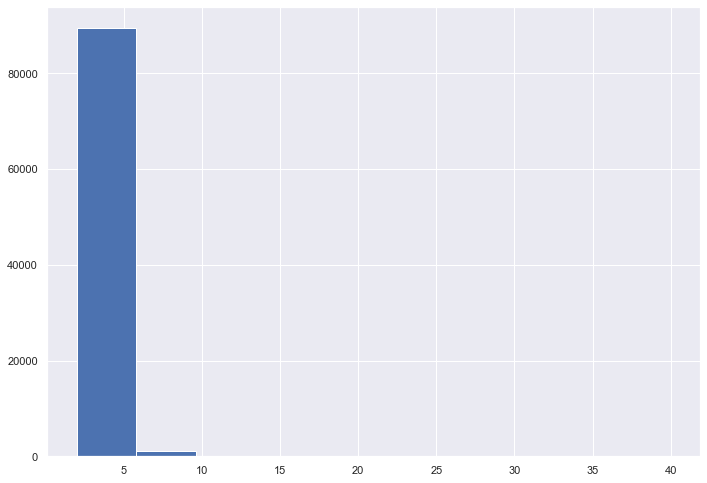

In [18]:
df_team_memberships_3["Members"].hist()

In [19]:
df_team_memberships_3.sort_values("Members",ascending=False)

,TeamId,Members,CompetitionId,MedalPoint
5260049,9021,40,2589,1.0
2369659,439016,34,5916,1.0
4345069,74305,25,3638,3.0
4569120,77642,24,3756,1.0
2190225,41125,24,3445,3.0
...,...,...,...,...
1943999,375078,2,5357,0.0
1944200,3751075,2,13451,0.0
1944256,3751172,2,13451,0.0
1944299,3751243,2,13451,0.0


<AxesSubplot:>

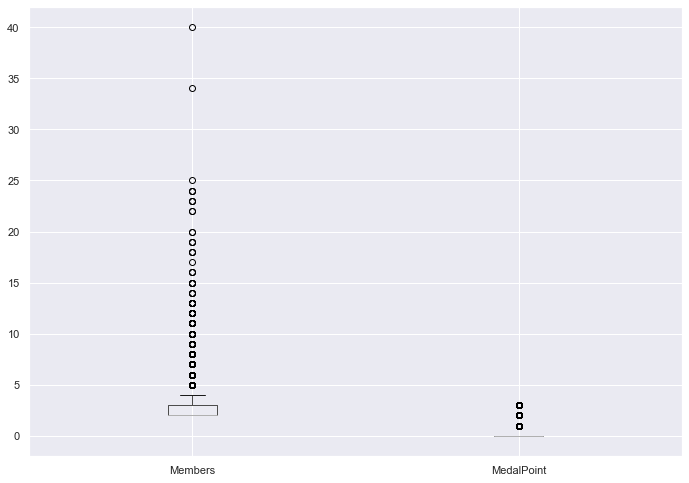

In [20]:
df_team_memberships_3.boxplot()

In [21]:
df_team_memberships.head()

,TeamId,UserId
0,518,635
1,526,839
2,527,816
3,528,778
4,529,747


In [22]:
df_team_memberships_graph = Combinations.create_combinations(df = df_team_memberships,group_by = "TeamId",name_col_1 ="UserId_1",name_col_2 = "UserId_2")
df_team_memberships_graph.head()

,TeamId,UserId_1,UserId_2
0,1000101,771602,611059
1,1000101,771602,599610
2,1000101,611059,599610
3,100044,2692,194687
4,100044,2692,208175


In [23]:
df_team_memberships_graph_2 = df_team_memberships_graph.merge(df_teams)
df_team_memberships_graph_2 = df_team_memberships_graph_2.merge(df_team_memberships_3)
#Creamos la fraccion que del valor de la medalla entre los competidores del team la cual sera el peso de la arista
df_team_memberships_graph_2["MedalPointFraccionated"] = df_team_memberships_graph_2["MedalPoint"] /df_team_memberships_graph_2["Members"]
df_team_memberships_graph_2.head()

,TeamId,UserId_1,UserId_2,CompetitionId,MedalPoint,Members,MedalPointFraccionated
0,1000101,771602,611059,7372,0.0,3,0.0
1,1000101,771602,599610,7372,0.0,3,0.0
2,1000101,611059,599610,7372,0.0,3,0.0
3,100044,2692,194687,3948,0.0,5,0.0
4,100044,2692,208175,3948,0.0,5,0.0


In [24]:
df_team_memberships_graph_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252332 entries, 0 to 252331
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TeamId                  252332 non-null  object 
 1   UserId_1                252332 non-null  object 
 2   UserId_2                252332 non-null  object 
 3   CompetitionId           252332 non-null  object 
 4   MedalPoint              252332 non-null  float64
 5   Members                 252332 non-null  int64  
 6   MedalPointFraccionated  252332 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 15.4+ MB


In [25]:
df_team_memberships_graph_2[(df_team_memberships_graph_2["UserId_1"]=="43883") | (df_team_memberships_graph_2["UserId_2"]=="43883")]

,TeamId,UserId_1,UserId_2,CompetitionId,MedalPoint,Members,MedalPointFraccionated
27128,16998,42832,43883,2748,2.0,23,0.086957
27149,16998,42831,43883,2748,2.0,23,0.086957
27169,16998,6133,43883,2748,2.0,23,0.086957
27188,16998,33583,43883,2748,2.0,23,0.086957
27206,16998,43882,43883,2748,2.0,23,0.086957
...,...,...,...,...,...,...,...
116304,41126,43883,97238,3446,3.0,24,0.125000
116305,41126,43883,97245,3446,3.0,24,0.125000
116306,41126,43883,97248,3446,3.0,24,0.125000
116307,41126,43883,97342,3446,3.0,24,0.125000


In [26]:
df_team_memberships_graph_3 = df_team_memberships_graph_2[["UserId_1","UserId_2","MedalPoint"]].groupby(["UserId_1","UserId_2"]).size().reset_index()
df_team_memberships_graph_3.rename(columns={0:"weight"},inplace=True)
df_team_memberships_graph_3.head()

,UserId_1,UserId_2,weight
0,10000270,8243312,3
1,10000270,9829581,2
2,1000033,1003122,1
3,1000033,1214207,1
4,1000033,1581982,1


In [27]:
df_team_memberships_graph_3.sort_values("weight",ascending=False)

,UserId_1,UserId_2,weight
165603,637722,2360956,60
103873,3597476,3594546,32
236,100236,149507,29
49696,2029256,2711607,27
40241,1788308,1918280,27
...,...,...,...
75471,2679958,2723843,1
75472,2679958,2731468,1
75473,2679959,339839,1
75474,2679963,5260576,1


In [28]:
print(df_team_memberships_graph_2.shape)
print(df_team_memberships_graph_3.shape)

(252332, 7)
(212459, 3)


In [29]:
#MultiGraph
df_team_memberships_graph_3.to_csv(r"../data/processed/Graph_Teams.csv",index=False)

: 

## User Participants in Competition

In [28]:
df_team_memberships = pd.read_csv(r"../data/interim/TeamMemberships.csv",dtype=str)
df_team_memberships.head()

,TeamId,UserId
0,518,635
1,526,839
2,527,816
3,528,778
4,529,747


In [29]:
df_teams = pd.read_csv(r"../data/interim/Teams.csv",dtype=str)
df_teams.head()

,TeamId,CompetitionId,TeamLeaderId,TeamName,Medal,PrivateLeaderboardRank
0,496,2435,647,team1,NaN,83.0
1,497,2435,619,jonp,3.0,25.0
2,499,2435,663,Bwaas,NaN,100.0
3,500,2435,673,Thylacoleo,3.0,23.0
4,501,2435,435,pjonesdotcda,NaN,80.0


In [30]:
df_teams.shape

(5357344, 6)

In [31]:
df_teams["Medal"].fillna(0,inplace=True)
df_teams["Medal"] = df_teams["Medal"].astype(float)
df_teams[df_teams["Medal"]>0].shape

(47379, 6)

In [32]:
# Solo el 1% de los participantes consigueron un podio con medallas ganadas en competiciones
47379/5357344*100

0.8843747946743759

In [33]:
df_teams_part = df_teams.groupby(["CompetitionId"]).size().reset_index()
df_teams_part.rename(columns={0:"Participants"},inplace=True)
df_teams_part.head()

,CompetitionId,Participants
0,10001,20
1,10006,168
2,10012,9046
3,10014,1033
4,10025,12790


array([[<AxesSubplot:title={'center':'Participants'}>]], dtype=object)

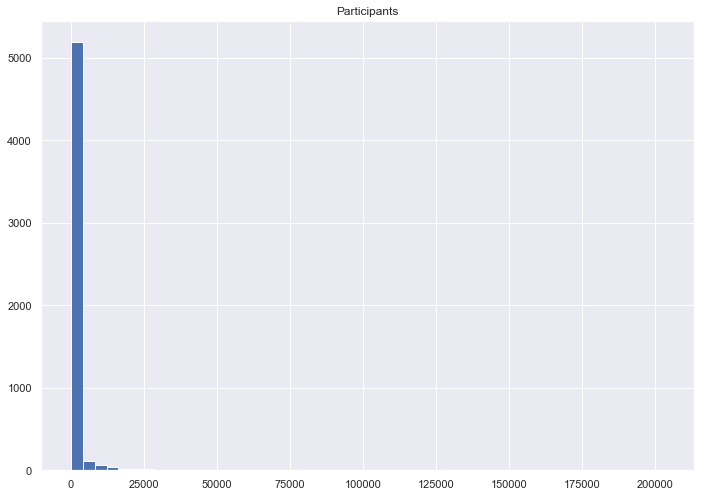

In [34]:
df_teams_part.hist(bins=50)

In [35]:
Validator.validar_numerico(df_teams_part,["Participants"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Zero,%Zero,Unico,Media,Min,Max,IQRMAX,3STD,P10,P25,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,Participants,5485,0,0.0,0,0.0,0,0.0,970,976.73,1,203279,260.0,16400.39,5.0,15.0,41.0,113.0,692.0,4555.4,23553.44,809,14.75,92,1.68,548,9.99,275,5.01,55,1.0


In [36]:
# Decidimos prescindir de las competiciones que tengan participantes fuera del rango intercuantilico (Removemos como outliers el 7% de las competiciones)
df_teams_part = df_teams_part[df_teams_part["Participants"]<260]
Validator.validar_numerico(df_teams_part,["Participants"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Zero,%Zero,Unico,Media,Min,Max,IQRMAX,3STD,P10,P25,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,Participants,4671,0,0.0,0,0.0,0,0.0,248,50.16,1,258,152.0,209.57,5.0,12.0,31.0,68.0,126.0,171.0,232.0,332,7.11,117,2.5,467,10.0,232,4.97,46,0.98


array([[<AxesSubplot:title={'center':'Participants'}>]], dtype=object)

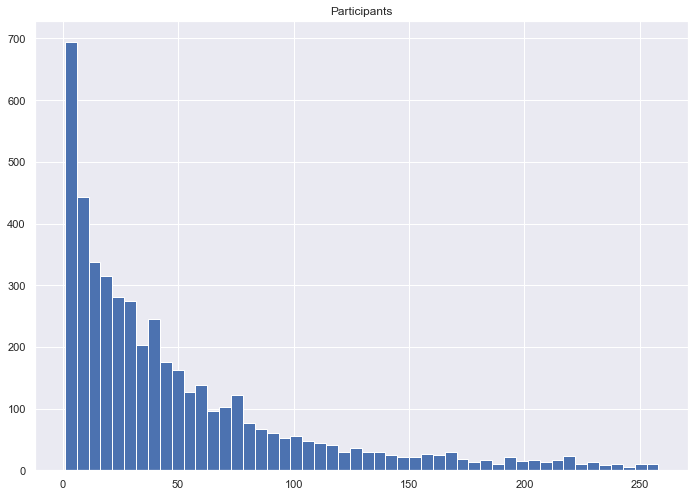

In [37]:
df_teams_part.hist(bins=50)

In [38]:
df_teams[(df_teams["CompetitionId"]=="2435") & (df_teams["Medal"]>0)].shape

(42, 6)

In [39]:
# Mantenemos solo a los equipos que hayan participado en las competiciones acotadas (habiendo borrado los outliers)
df_teams = df_teams[df_teams["CompetitionId"].isin(df_teams_part["CompetitionId"].tolist())]
df_teams= df_teams[["TeamId","CompetitionId"]]
df_teams.shape

(234317, 2)

In [40]:
df_competition_participant = pd.merge(df_teams,df_team_memberships,on="TeamId",how="inner")
df_competition_participant = df_competition_participant[["CompetitionId","UserId"]]
df_competition_participant.drop_duplicates(inplace=True)
df_competition_participant.head()

,CompetitionId,UserId
0,2488,62
1,2488,5251
2,2488,5298
3,2488,424
4,2488,5111


In [41]:
df_competition_participant.shape

(226128, 2)

In [42]:
df_comp_participant_graph = Combinations.create_combinations(df = df_competition_participant,group_by = "CompetitionId",name_col_1 ="UserId_1",name_col_2 = "UserId_2")
df_comp_participant_graph.head()

,CompetitionId,UserId_1,UserId_2
0,10001,1549002,1984379
1,10001,1549002,1985614
2,10001,1549002,1984443
3,10001,1549002,1984237
4,10001,1549002,1985685


In [43]:
# Creamos la variable weigth que representan la frecuencia de que un usuario haya competido con otro usuario en competencias
df_comp_participant_graph_2 = df_comp_participant_graph[["UserId_1","UserId_2"]].groupby(["UserId_1","UserId_2"]).size().reset_index()
df_comp_participant_graph_2.rename(columns={0:"weight"},inplace=True)
df_comp_participant_graph_2.head()

,UserId_1,UserId_2,weight
0,1000025,10148801,1
1,1000025,10668599,1
2,1000025,1138223,1
3,1000025,1169450,1
4,1000025,1299826,1


In [44]:
print(df_comp_participant_graph.shape)
print(df_comp_participant_graph_2.shape)

(11946680, 3)
(10428791, 3)


In [45]:
#MultiGraph
df_comp_participant_graph_2.to_csv(r"../data/processed/Graph_CompParticipant.csv",index=False)

## User Forum Messages

In [46]:
df_forum_messages = pd.read_csv(r"../data/interim/ForumMessages.csv",dtype=str)
df_forum_messages.head()

,ForumTopicId,UserId,Medal
0,2,368,NaN
1,16,368,NaN
2,16,368,NaN
3,20,368,NaN
4,20,368,NaN


In [47]:
print(df_forum_messages.shape)

(1526307, 3)


In [48]:
#Eliminamos los duplicados ya que no nos interesa si una persona comento 1 o 100 veces sobre un mismo foro, solo nos interesa si participo o no
df_forum_messages = df_forum_messages[["ForumTopicId","UserId"]].drop_duplicates()
print(df_forum_messages.shape)

(1040836, 2)


In [49]:
df_forum_messages_size = df_forum_messages.groupby("ForumTopicId").size().to_frame('Comments').reset_index()
df_forum_messages_size.head()

,ForumTopicId,Comments
0,1,9
1,10,3
2,100,4
3,1000,1
4,10000,2


In [50]:
df_forum_messages = df_forum_messages.merge(df_forum_messages_size, how='left', on=['ForumTopicId'])
print(df_forum_messages.shape)

(1040836, 3)


In [51]:
#Nos interesa foros donde al menos hayan interactuado 2 personas
df_forum_messages = df_forum_messages[df_forum_messages["Comments"]>1]
print(df_forum_messages.shape)

(953715, 3)


In [52]:
df_forum_messages.head()

,ForumTopicId,UserId,Comments
0,2,368,3
2,20,368,6
3,26,368,33
5,30,368,3
6,34,368,8


In [53]:
df_forum_messages["ForumTopicId_Int"] = df_forum_messages["ForumTopicId"].astype(int)
Validator.validar_numerico(df_forum_messages,["ForumTopicId_Int","Comments"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Zero,%Zero,Unico,Media,Min,Max,IQRMAX,3STD,P10,P25,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,ForumTopicId_Int,953715,0,0.0,0,0.0,0,0.0,173248,155000.57,1,334148,489444.5,441227.89,31593.0,69112.0,146147.0,237245.0,295286.6,311899.0,329232.86,0,0.00,0,0.00,95372,10.00,47684,5.00,9538,1.0
0,Comments,953715,0,0.0,0,0.0,0,0.0,241,627.63,2,23022,49.0,11248.95,2.0,4.0,8.0,22.0,86.0,536.0,23022.00,133664,14.02,23022,2.41,95066,9.97,47366,4.97,0,0.0


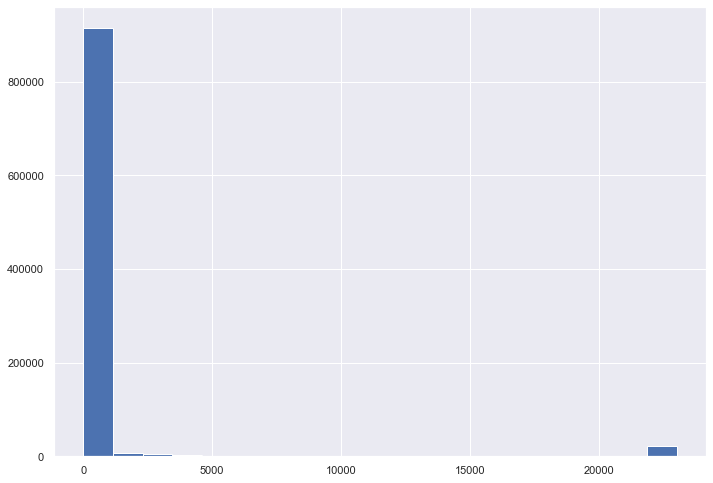

In [54]:
plt.hist(df_forum_messages["Comments"],bins=20)
plt.show()

In [55]:
df_forum_messages[df_forum_messages["Comments"]>80].head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int
252,35118,368,157,35118
261,60914,368,832,60914
271,137078,368,145,137078
479,27729,393,326,27729
595,36940,464,344,36940


In [56]:
df_forums = pd.read_csv(r"../data/interim/Forums.csv",dtype=str)
df_forums.head()

,ForumId,ParentForumId,Title
0,1,8,Predict HIV Progression
1,2,8,Forecast Eurovision Voting
2,3,8,World Cup 2010 - Take on the Quants
3,4,8,INFORMS Data Mining Contest 2010
4,5,NaN,Active Competitions


In [57]:
df_forum_topics = pd.read_csv(r"../data/interim/ForumTopics.csv",dtype=str)
df_forum_topics.head()

,ForumTopicId,ForumId,Title,TotalViews,TotalMessages,Score
0,1,1,A few techniques you might try:,9405.0,19.0,0.0
1,2,1,Question regarding algorithms used,2185.0,3.0,0.0
2,3,1,Question about data,2121.0,3.0,0.0
3,4,1,Biased sets,2780.0,4.0,1.0
4,5,1,Non-standard nucleotide codings,2045.0,2.0,0.0


In [58]:
df_forums_2 = df_forums.copy()
df_forums_2 = df_forums_2[["ForumId","ParentForumId","Title"]]
df_forum_topics = df_forum_topics[["ForumTopicId","ForumId"]]
df_forum_topics_merge = df_forum_topics.merge(df_forums_2,how="left",on=["ForumId"])
df_forum_topics_merge.rename(columns={"Title":"ForumTopicName"},inplace=True)

#Cambio el codigo del foro para sacar el nombre del padre
df_forums_parent = df_forums_2.copy()
df_forums_parent = df_forums_parent["ParentForumId"].dropna()
df_forums_2 = df_forums_2[["ForumId","Title"]]
df_forums_2.rename(columns={"ForumId":"ParentForumId","Title":"ParentForumName"},inplace=True)
df_forum_topics_merge_2 = df_forum_topics_merge.merge(df_forums_2,how="left",on=["ParentForumId"])

df_forum_topics_merge_2.head()

,ForumTopicId,ForumId,ParentForumId,ForumTopicName,ParentForumName
0,1,1,8,Predict HIV Progression,Past Competitions
1,2,1,8,Predict HIV Progression,Past Competitions
2,3,1,8,Predict HIV Progression,Past Competitions
3,4,1,8,Predict HIV Progression,Past Competitions
4,5,1,8,Predict HIV Progression,Past Competitions


In [59]:
df_forum_topics_merge_2["ParentForumName"].value_counts()

General                65287
Past Competitions      64636
Public Datasets        16330
Active Competitions     2524
Name: ParentForumName, dtype: int64

In [60]:
df_forum_topics_merge_2["ParentForumId"].value_counts()

9       65287
8       64636
1023    16330
5        2524
52        544
6         456
198       335
91        214
Name: ParentForumId, dtype: int64

In [61]:
df_forum_topics_merge_2[df_forum_topics_merge_2["ParentForumId"]=="52"].head()

,ForumTopicId,ForumId,ParentForumId,ForumTopicName,ParentForumName
21661,856,54,52,UW STAT331 Linear Models Contest,NaN
21662,857,54,52,UW STAT331 Linear Models Contest,NaN
21663,858,54,52,UW STAT331 Linear Models Contest,NaN
21664,859,54,52,UW STAT331 Linear Models Contest,NaN
21665,860,54,52,UW STAT331 Linear Models Contest,NaN


In [62]:
df_forums[df_forums["ForumId"]=="51"]

,ForumId,ParentForumId,Title
24,51,8,Give Me Some Credit


In [63]:
df_forum_join = df_forum_messages.merge(df_forum_topics_merge_2,how="left",on=["ForumTopicId"])
df_forum_join.head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int,ForumId,ParentForumId,ForumTopicName,ParentForumName
0,2,368,3,2,1,8,Predict HIV Progression,Past Competitions
1,20,368,6,20,1,8,Predict HIV Progression,Past Competitions
2,26,368,33,26,15,9,General,General
3,30,368,3,30,4,8,INFORMS Data Mining Contest 2010,Past Competitions
4,34,368,8,34,4,8,INFORMS Data Mining Contest 2010,Past Competitions


<AxesSubplot:xlabel='ParentForumName', ylabel='Comments'>

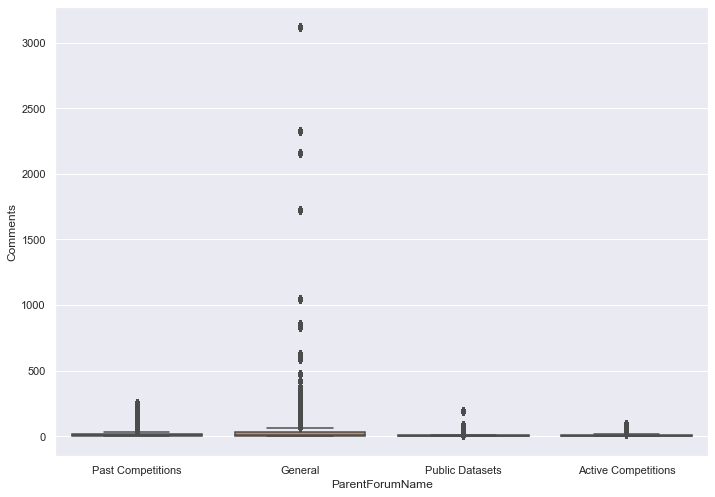

In [64]:
#Observamos que la mayoria de ForumParents que tienen mas de 500 (PERCENTIL 95) comentarios son del general, asi que haremos un zoom sobre cuales son
sns.boxplot(data=df_forum_join, x='ParentForumName', y='Comments')

In [65]:
df_forum_join[df_forum_join["Comments"]>500]["ParentForumName"].value_counts()

General    13271
Name: ParentForumName, dtype: int64

In [66]:
df_forum_join[df_forum_join["Comments"]>500].head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int,ForumId,ParentForumId,ForumTopicName,ParentForumName
246,60914,368,832,60914,15,9,General,General
563,111053,583,23022,111053,16860,NaN,Notebooks,NaN
976,256646,937,3754,256646,16860,NaN,Notebooks,NaN
2060,111053,1327,23022,111053,16860,NaN,Notebooks,NaN
2245,256489,1408,2162,256489,208,9,Getting Started,General


<AxesSubplot:xlabel='ForumTopicName', ylabel='Comments'>

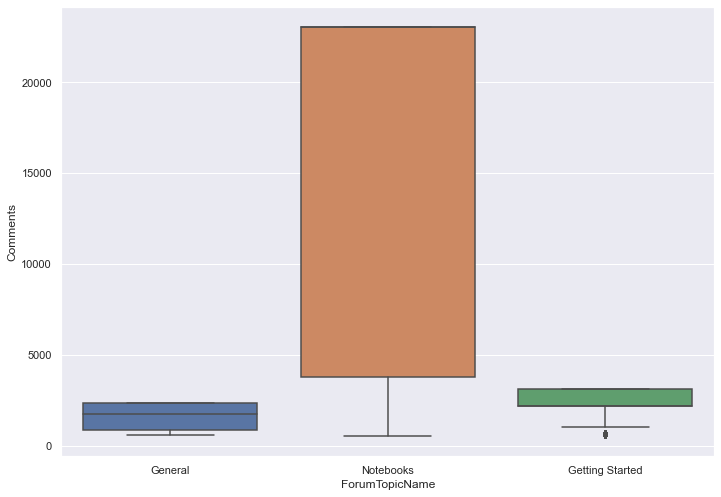

In [67]:
#Los foros con mas de 500 comentarios son los foros generales, algunos de general y getting started
sns.boxplot(data=df_forum_join[df_forum_join["Comments"]>500], x='ForumTopicName', y='Comments')

In [68]:
df_forum_messages.head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int
0,2,368,3,2
2,20,368,6,20
3,26,368,33,26
5,30,368,3,30
6,34,368,8,34


In [69]:
Validator.validar_numerico(df_forum_messages,["ForumTopicId_Int","Comments"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Zero,%Zero,Unico,Media,Min,Max,IQRMAX,3STD,P10,P25,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,ForumTopicId_Int,953715,0,0.0,0,0.0,0,0.0,173248,155000.57,1,334148,489444.5,441227.89,31593.0,69112.0,146147.0,237245.0,295286.6,311899.0,329232.86,0,0.00,0,0.00,95372,10.00,47684,5.00,9538,1.0
0,Comments,953715,0,0.0,0,0.0,0,0.0,241,627.63,2,23022,49.0,11248.95,2.0,4.0,8.0,22.0,86.0,536.0,23022.00,133664,14.02,23022,2.41,95066,9.97,47366,4.97,0,0.0


In [70]:
#Decidimos prescindir de estos foros que tiene >=500 mensajes y que representan menos del 5% del dataset
df_forum_messages = df_forum_messages[df_forum_messages["Comments"]<500]
Validator.validar_numerico(df_forum_messages,["ForumTopicId_Int","Comments"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Zero,%Zero,Unico,Media,Min,Max,IQRMAX,3STD,P10,P25,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,ForumTopicId_Int,905813,0,0.0,0,0.0,0,0.0,173229,156887.10,1,334148,494216.0,445733.61,31861.0,69251.0,151001.0,239237.0,296948.0,312861.0,329412.0,0,0.00,0,0.0,90580,10.00,45287,5.00,8966,0.99
0,Comments,905813,0,0.0,0,0.0,0,0.0,223,21.42,2,477,40.5,159.45,2.0,3.0,7.0,18.0,47.0,89.0,268.0,104071,11.49,20797,2.3,89834,9.92,44870,4.95,8812,0.97


In [71]:
df_forum_messages_graph = Combinations.create_combinations(df = df_forum_messages[["ForumTopicId","UserId"]],group_by = "ForumTopicId",name_col_1 ="UserId_1",name_col_2 = "UserId_2")
df_forum_messages_graph.head()


,ForumTopicId,UserId_1,UserId_2
0,1,368,478
1,1,368,673
2,1,368,703
3,1,368,728
4,1,368,808


In [72]:
df_forum_messages_graph.shape

(9250249, 3)

In [73]:
# Creamos la variable weigth que representan la frecuencia de que un usuario haya interactuado con otro en algun foro
df_forum_messages_graph_2 = df_forum_messages_graph[["UserId_1","UserId_2"]].groupby(["UserId_1","UserId_2"]).size().reset_index()
df_forum_messages_graph_2.rename(columns={0:"weight"},inplace=True)
df_forum_messages_graph_2.head()

,UserId_1,UserId_2,weight
0,10000014,10030651,7
1,10000014,10135089,1
2,10000014,10215702,1
3,10000014,10275991,4
4,10000014,10277092,1


In [74]:
print(df_forum_messages_graph.shape)
print(df_forum_messages_graph_2.shape)

(9250249, 3)
(8085584, 3)


In [75]:
#MultiGraph
df_forum_messages_graph_2.to_csv(r"../data/processed/Graph_ForumMessages.csv",index=False)